<a href="https://colab.research.google.com/github/TakueGhost/Takudzwa-Chirindo/blob/main/Copy_of_sentiment_analysis_and_news_stock_market_trend_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Jeremiah Muchazondida 
# Takudzwa Chirindo
# Pride Mudondo

## Investigating the Predictive Power of Financial News Sentiment:
## Developing Machine Learning Models to Determine the Influence of Trending News on Stock Market Trends

In [ ]:
# Install necessary packages
!pip install yfinance nltk

# Import all required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import warnings
warnings.filterwarnings('ignore')

print("All libraries installed and imported successfully!")

All libraries installed and imported successfully!


In [ ]:
# Downloading the VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')
print("VADER lexicon downloaded!")

VADER lexicon downloaded!


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
import pandas as pd
import yfinance as yf
from google.colab import drive

drive.mount('/content/drive')

base_path = '/content/drive/My Drive/datasets/stock_market_model/'

# LOAD CLEANED S&P500
print("Loading cleaned S&P500 dataset...")
clean_sp500_file = 'clean_sp500_stocks.csv'
df_sp500 = pd.read_csv(base_path + clean_sp500_file)

print("Clean S&P500 shape:", df_sp500.shape)
print(df_sp500.head())

# Rename columns to match yfinance
df_sp500 = df_sp500.rename(columns={
    'date': 'Date',
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'adj_close': 'Adj Close',
    'volume': 'Volume',
    'symbol': 'Symbol'
})

df_sp500['Date'] = pd.to_datetime(df_sp500['Date'])

# DOWNLOAD SPY FROM YFINANCE
ticker = "SPY"
start_date = "2008-01-01"
end_date = "2025-12-31"

print("\nDownloading SPY from yfinance...")
df_yf = yf.download(ticker, start=start_date, end=end_date)

# Flatten MultiIndex columns if present
if isinstance(df_yf.columns, pd.MultiIndex):
    df_yf.columns = [col[0] for col in df_yf.columns]

df_yf = df_yf.reset_index()
df_yf['Date'] = pd.to_datetime(df_yf['Date'])

print("SPY (yfinance) shape:", df_yf.shape)
print(df_yf.head())

# MERGE DATA
print("\nMerging cleaned S&P500 with SPY...")

df_spy = pd.merge(
    df_yf,
    df_sp500,
    on='Date',
    how='left',
    suffixes=('_SPY', '_SP500')
)

print("Merged df_spy shape:", df_spy.shape)
print(df_spy.head())


Mounted at /content/drive
Loading cleaned S&P500 dataset...
Clean S&P500 shape: (300000, 8)
         date symbol        open        high         low       close  \
0  2015-02-25    PKG   82.639999   82.760002   81.669998   82.099998   
1  2012-07-17    PPG   51.294998   52.160000   50.959999   52.064999   
2  2022-08-12   FFIV  170.880005  172.880005  170.550003  172.649994   
3  2021-10-26   ANSS  377.160004  381.220001  375.920013  376.470001   
4  2014-09-11    HLT   50.889599   51.710400   50.602322   50.971680   

    adj_close     volume  
0   60.593231   585900.0  
1   42.514153  1810400.0  
2  172.649994   363800.0  
3  376.470001   225100.0  
4   48.341377  3296248.0  



[*********************100%***********************]  1 of 1 completed

SPY (yfinance) shape: (4516, 6)
        Date       Close        High         Low        Open     Volume
0 2008-01-02  104.084915  105.564362  103.330841  105.233998  204935600
1 2008-01-03  104.034645  104.487098  103.467293  104.070556  125133300
2 2008-01-04  101.485115  103.014828  101.197850  102.943007  232330900
3 2008-01-07  101.398949  102.145845  100.616142  101.844213  234991000
4 2008-01-08   99.761543  102.627050   99.424001  102.038153  326365700

Merging cleaned S&P500 with SPY...
Merged df_spy shape: (300748, 13)
        Date   Close_SPY    High_SPY     Low_SPY    Open_SPY  Volume_SPY  \
0 2008-01-02  104.084915  105.564362  103.330841  105.233998   204935600   
1 2008-01-03  104.034645  104.487098  103.467293  104.070556   125133300   
2 2008-01-04  101.485115  103.014828  101.197850  102.943007   232330900   
3 2008-01-07  101.398949  102.145845  100.616142  101.844213   234991000   
4 2008-01-08   99.761543  102.627050   99.424001  102.038153   326365700   

  Symbol 

In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive', force_remount=True)

# Loading dataset
file_path = '/content/drive/My Drive/datasets/stock_market_model/processed_news_data.xlsx'
df_news = pd.read_excel(file_path)

print(f"Initial data shape: {df_news.shape}")

# Dropping obvious missing headline/date rows
df_news = df_news.dropna(subset=['headline', 'date'])
print(f"After removing missing headline/date: {len(df_news)} rows remain")
print("\nConverting 'date' to datetime...")
df_news['date'] = pd.to_datetime(df_news['date'], errors='coerce', utc=True)

# Dropping any rows where conversion failed
bad_dates = df_news['date'].isna().sum()
if bad_dates > 0:
    print(f"Found {bad_dates} invalid date entries — removing them.")
    df_news = df_news.dropna(subset=['date'])

# Cleaning up 'stock' column just in case
df_news['stock'] = df_news['stock'].astype(str).str.strip().str.upper()

# Displaying summary
print("\nData cleaned successfully!")
print(f"Final dataset shape: {df_news.shape}")
print(f"Total articles: {len(df_news)}")
print(f"Date range: {df_news['date'].min()} to {df_news['date'].max()}")
print(f"Unique stocks: {df_news['stock'].nunique()}")
print(f"Most common stocks:\n{df_news['stock'].value_counts().head(10)}")

Mounted at /content/drive
Initial data shape: (1048575, 3)
After removing missing headline/date: 1047930 rows remain

Converting 'date' to datetime...
Found 643 invalid date entries — removing them.

Data cleaned successfully!
Final dataset shape: (1047287, 3)
Total articles: 1047287
Date range: 2009-02-14 19:02:00+00:00 to 2025-12-09 00:00:00+00:00
Unique stocks: 2991
Most common stocks:
stock
NVDA    16880
NFLX    16801
JNJ     16700
MA      16038
ADBE    15915
BAC     15676
CRM     15277
PG      15100
AAPL    14422
META    14006
Name: count, dtype: int64


In [ ]:
# === Financial Data Preparation ===
df_financial = df_spy.copy()
df_financial = df_financial.sort_values('Date').reset_index(drop=True)

# Check for duplicate 'Close' columns
print("Columns with 'Close' in name:")
close_cols = [col for col in df_financial.columns if 'Close' in str(col)]
print(close_cols)

# If multiple Close columns exist, we need to select the SPY one
if len(close_cols) > 1:
    print("\nMultiple 'Close' columns detected. Selecting 'Close_SPY' as primary...")
    # Identify which one is SPY (assuming 'Close_SPY' or similar)
    spy_close_col = None
    for col in close_cols:
        if 'SPY' in col or 'spy' in col.lower():
            spy_close_col = col
            break
    if spy_close_col:
        # Rename the SPY Close column to just 'Close'
        df_financial = df_financial.rename(columns={spy_close_col: 'Close'})
        # Drop other Close columns if needed
        other_close_cols = [col for col in close_cols if col != spy_close_col]
        if other_close_cols:
            print(f"Dropping other Close columns: {other_close_cols}")
            df_financial = df_financial.drop(columns=other_close_cols)
    else:
        # If no clear SPY column, use the first one
        print(f"No SPY identifier found. Using '{close_cols[0]}' as 'Close'")
        df_financial = df_financial.rename(columns={close_cols[0]: 'Close'})
        df_financial = df_financial.drop(columns=close_cols[1:])
else:
    # If only one Close column, rename it to 'Close'
    df_financial = df_financial.rename(columns={close_cols[0]: 'Close'})

# Do the same for other price columns if needed
price_columns = ['Open', 'High', 'Low', 'Volume']
for price_col in price_columns:
    matching_cols = [col for col in df_financial.columns if price_col in str(col)]
    if len(matching_cols) >= 1:
        # Find SPY version if exists
        spy_version = None
        for col in matching_cols:
            if 'SPY' in col or 'spy' in col.lower():
                spy_version = col
                break

        if spy_version:
            df_financial = df_financial.rename(columns={spy_version: price_col})
            # Keep only this one
            other_cols = [col for col in matching_cols if col != spy_version]
            if other_cols:
                df_financial = df_financial.drop(columns=other_cols)
        else:
            # Use first one
            df_financial = df_financial.rename(columns={matching_cols[0]: price_col})
            df_financial = df_financial.drop(columns=matching_cols[1:])

# Now we should have single columns for Close, Open, High, Low, Volume
print("\nUpdated columns:")
print(df_financial.columns.tolist())

# === Target Variable ===
# Now this should work without error
df_financial['Target'] = (df_financial['Close'].shift(-1) > df_financial['Close']).astype(int)

# === Technical Indicators ===
# Continue with your existing code...
df_financial['SMA_5'] = df_financial['Close'].rolling(5).mean()
df_financial['SMA_10'] = df_financial['Close'].rolling(10).mean()
df_financial['SMA_20'] = df_financial['Close'].rolling(20).mean()
df_financial['SMA_50'] = df_financial['Close'].rolling(50).mean()

df_financial['EMA_12'] = df_financial['Close'].ewm(span=12).mean()
df_financial['EMA_26'] = df_financial['Close'].ewm(span=26).mean()

df_financial['Price_Range'] = (df_financial['High'] - df_financial['Low']) / df_financial['Close']
df_financial['Price_Change'] = df_financial['Close'].pct_change()
df_financial['Gap'] = (df_financial['Open'] - df_financial['Close'].shift(1)) / df_financial['Close'].shift(1)

df_financial['Volume_Change'] = df_financial['Volume'].pct_change()
df_financial['Volume_SMA_5'] = df_financial['Volume'].rolling(5).mean()

# Ensure both Series for safe division
df_financial['Volume'] = df_financial['Volume'].astype(float)
df_financial['Volume_SMA_5'] = df_financial['Volume_SMA_5'].astype(float)

df_financial['Volume_Ratio'] = df_financial['Volume'] / df_financial['Volume_SMA_5']

# RSI
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df_financial['RSI'] = calculate_rsi(df_financial['Close'])

# MACD
df_financial['MACD'] = df_financial['EMA_12'] - df_financial['EMA_26']
df_financial['MACD_Signal'] = df_financial['MACD'].ewm(span=9).mean()
df_financial['MACD_Histogram'] = df_financial['MACD'] - df_financial['MACD_Signal']

# Bollinger Bands
df_financial['BB_Middle'] = df_financial['Close'].rolling(20).mean()
df_financial['BB_Upper'] = df_financial['BB_Middle'] + 2 * df_financial['Close'].rolling(20).std()
df_financial['BB_Lower'] = df_financial['BB_Middle'] - 2 * df_financial['Close'].rolling(20).std()
df_financial['BB_Width'] = (df_financial['BB_Upper'] - df_financial['BB_Lower']) / df_financial['BB_Middle']
df_financial['BB_Position'] = (df_financial['Close'] - df_financial['BB_Lower']) / (df_financial['BB_Upper'] - df_financial['BB_Lower'])

# Drop NaNs
initial_shape = df_financial.shape[0]
df_financial.dropna(inplace=True)
final_shape = df_financial.shape[0]

print("\n✅ Financial data preprocessing completed!")
print(f"Removed {initial_shape - final_shape} rows with NaN values")
print(f"Final financial data shape: {df_financial.shape}")
print(f"Target distribution:\n{df_financial['Target'].value_counts()}")
print(f"Target proportion: {df_financial['Target'].mean():.3f}")

Columns with 'Close' in name:
['Close_SPY', 'Close_SP500', 'Adj Close']

Multiple 'Close' columns detected. Selecting 'Close_SPY' as primary...
Dropping other Close columns: ['Close_SP500', 'Adj Close']

Updated columns:
['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Symbol']

✅ Financial data preprocessing completed!
Removed 248164 rows with NaN values
Final financial data shape: (52584, 29)
Target distribution:
Target
0    52584
Name: count, dtype: int64
Target proportion: 0.000


In [ ]:
# Enhancing News Data Preprocessing and Sentiment Analysis

# Initializing VADER Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

print(f"Processing {len(df_news)} news articles...")
df_news['date_only'] = df_news['date'].dt.date
df_news['date_only'] = pd.to_datetime(df_news['date_only'])

# Function to get sentiment scores with error handling
def get_sentiment_scores(text):
    try:
        if isinstance(text, str) and len(text.strip()) > 0:
            scores = sid.polarity_scores(text)
            return scores
        else:
            return {'neg': 0, 'neu': 1, 'pos': 0, 'compound': 0}
    except:
        return {'neg': 0, 'neu': 1, 'pos': 0, 'compound': 0}

# Applying sentiment analysis to each headline
print("Performing sentiment analysis on headlines...")
chunk_size = 10000
sentiment_scores = []

for i in range(0, len(df_news), chunk_size):
    chunk = df_news.iloc[i:i + chunk_size]
    chunk_scores = chunk['headline'].apply(get_sentiment_scores)
    sentiment_scores.extend(chunk_scores)
    if i % 100000 == 0:
        print(f"Processed {i}/{len(df_news)} articles...")

df_news['Sentiment_Scores'] = sentiment_scores

# Extracting individual sentiment scores
df_news['Negative'] = df_news['Sentiment_Scores'].apply(lambda x: x['neg'])
df_news['Neutral'] = df_news['Sentiment_Scores'].apply(lambda x: x['neu'])
df_news['Positive'] = df_news['Sentiment_Scores'].apply(lambda x: x['pos'])
df_news['Compound'] = df_news['Sentiment_Scores'].apply(lambda x: x['compound'])

# Dropping the original scores column to save memory
df_news = df_news.drop('Sentiment_Scores', axis=1)

print("Sentiment analysis completed!")

# Filtering for market-wide news or SPY-related news
market_keywords = [
    # Market & index terms
    'market', 'stocks', 'stock market', 'rates', 'trading', 'spy', 'equities', 'shares', 'index', 'indices',
    'dow', 's&p', 'sp500', 'nasdaq', 'nyse', 'wall street', 'ftse', 'dax', 'nikkei',
    'tsx', 'asx', 'sensex', 'bovespa', 'bull', 'bear', 'trading session', 'market close'

    # Economic & macro terms
    'economy', 'economic', 'inflation', 'cpi', 'ppi', 'gdp', 'growth', 'unemployment',
    'jobs', 'employment', 'labor market', 'recession', 'recovery', 'stagnation',
    'slowdown', 'housing', 'mortgage', 'real estate', 'deficit', 'surplus',
    'exports', 'imports', 'trade balance', 'manufacturing', 'industrial',
    'production', 'consumer confidence',

    # Finance & investing terms
    'invest', 'investor', 'investment', 'fund', 'hedge fund', 'etf', 'mutual fund',
    'portfolio', 'bond', 'treasury', 'yield', 'dividend', 'ipo', 'earnings',
    'forecast', 'valuation', 'profit', 'loss', 'balance sheet', 'quarterly results',

    # Monetary policy & institutions
    'fed', 'federal reserve', 'interest rate', 'rate hike', 'rate cut',
    'central bank', 'ecb', 'boe', 'boj', 'imf', 'world bank', 'monetary policy',
    'tightening', 'easing', 'quantitative easing', 'qe', 'liquidity', 'stimulus',

    # Commodities & currencies
    'oil', 'gold', 'silver', 'commodity', 'futures', 'forex', 'currency',
    'exchange rate', 'usd', 'dollar', 'euro', 'yen', 'pound', 'crypto', 'bitcoin',
    'ethereum', 'cryptocurrency', 'blockchain',

    # Market events & risks
    'volatility', 'crash', 'selloff', 'rally', 'bull market', 'bear market',
    'bubble', 'correction', 'pandemic', 'geopolitical', 'sanctions', 'war',
    'conflict', 'election', 'shutdown', 'policy', 'regulation', 'bank', 'default',
    'bankruptcy', 'credit', 'debt ceiling'
]

# function to identify market-related news
def is_market_news(headline):
    if isinstance(headline, str):
        headline_lower = headline.lower()
        return any(keyword in headline_lower for keyword in market_keywords)
    return False

print("Identifying market-related news...")
df_news['is_market_news'] = df_news['headline'].apply(is_market_news)

print(f"Total market-related articles: {df_news['is_market_news'].sum()}")
print(f"Market-related articles percentage: {df_news['is_market_news'].mean():.2%}")

# Aggregating sentiment by date (multiple articles per day) - using only market-related news
market_news = df_news[df_news['is_market_news']]

daily_sentiment = market_news.groupby('date_only').agg({
    'Negative': 'mean',
    'Neutral': 'mean',
    'Positive': 'mean',
    'Compound': 'mean',
    'headline': 'count'  # Count of articles per day
}).reset_index()

daily_sentiment = daily_sentiment.rename(columns={'headline': 'Article_Count', 'date_only': 'Date'})

print(f"\nDaily sentiment aggregation completed!")
print(f"Number of days with market news: {len(daily_sentiment)}")
print(f"Date range in market news: {daily_sentiment['Date'].min()} to {daily_sentiment['Date'].max()}")
print(f"Average market articles per day: {daily_sentiment['Article_Count'].mean():.1f}")

print("\nSample of daily sentiment data:")
print(daily_sentiment.head(10))

# Display sentiment statistics
print("\nSentiment Statistics for Market News:")
print(f"Average Compound Sentiment: {daily_sentiment['Compound'].mean():.4f}")
print(f"Sentiment Score Range: [{daily_sentiment['Compound'].min():.4f}, {daily_sentiment['Compound'].max():.4f}]")
print(f"Days with positive sentiment: {(daily_sentiment['Compound'] > 0).sum()}")
print(f"Days with negative sentiment: {(daily_sentiment['Compound'] < 0).sum()}")
print(f"Days with neutral sentiment: {(daily_sentiment['Compound'] == 0).sum()}")

Processing 1047287 news articles...
Performing sentiment analysis on headlines...
Processed 0/1047287 articles...
Processed 100000/1047287 articles...
Processed 200000/1047287 articles...
Processed 300000/1047287 articles...
Processed 400000/1047287 articles...
Processed 500000/1047287 articles...
Processed 600000/1047287 articles...
Processed 700000/1047287 articles...
Processed 800000/1047287 articles...
Processed 900000/1047287 articles...
Processed 1000000/1047287 articles...
Sentiment analysis completed!
Identifying market-related news...
Total market-related articles: 743738
Market-related articles percentage: 71.02%

Daily sentiment aggregation completed!
Number of days with market news: 4356
Date range in market news: 2009-02-14 00:00:00 to 2025-12-09 00:00:00
Average market articles per day: 170.7

Sample of daily sentiment data:
        Date  Negative   Neutral  Positive  Compound  Article_Count
0 2009-02-14  0.000000  0.678000  0.322000  0.226300              1
1 2009-04-22 

In [ ]:
# Data Merging

print("=== MERGING FINANCIAL AND NEWS DATA ===")

print(f"Initial News data shape: \n{daily_sentiment.info}")
print(f"Initial Financial data shape: \n{df_financial.info}")

# Ensure both Date columns are properly formatted
df_financial['Date'] = pd.to_datetime(df_financial['Date'])
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'])

print(f"Financial data date range: {df_financial['Date'].min()} to {df_financial['Date'].max()}")
print(f"News data date range: {daily_sentiment['Date'].min()} to {daily_sentiment['Date'].max()}")
print(f"Financial data shape: {df_financial.shape}")
print(f"News data shape: {daily_sentiment.shape}")

# Resetting indices to avoid MultiIndex issues
df_financial_clean = df_financial.reset_index(drop=True)
daily_sentiment_clean = daily_sentiment.reset_index(drop=True)

# Merging the datasets on Date
df_merged = pd.merge(df_financial_clean, daily_sentiment_clean, on='Date', how='inner')

print(f"\n MERGE SUCCESSFUL!")
print(f"Merged dataset shape: {df_merged.shape}")
print(f"Merged dataset shape: {df_merged.info}")
print(f"Date range: {df_merged['Date'].min()} to {df_merged['Date'].max()}")
print(f"\nMissing values:\n{df_merged.isnull().sum()}")

# Displaying the merged dataset info
print("\nMerged dataset columns:")
print(df_merged.columns.tolist())

# Showing sample of merged data
print("\nSample of merged data (showing key columns):")
sample_columns = ['Date', 'Close', 'Target', 'Compound', 'Positive', 'Negative', 'Article_Count']
print(df_merged[sample_columns].head(10))

# Data quality check
if len(df_merged) > 1000:
    print(f"\nEXCELLENT: {len(df_merged)} records available for modeling!")
    print("Sufficient data for robust model training.")
elif len(df_merged) > 500:
    print(f"\GOOD: {len(df_merged)} records available for modeling.")
    print("Sufficient for initial model training.")
else:
    print(f"\n⚠️ WARNING: Only {len(df_merged)} records available.")
    print("Insufficient Data for training")

=== MERGING FINANCIAL AND NEWS DATA ===
Initial News data shape: 
<bound method DataFrame.info of            Date  Negative   Neutral  Positive  Compound  Article_Count
0    2009-02-14  0.000000  0.678000  0.322000  0.226300              1
1    2009-04-22  0.266093  0.648651  0.085302 -0.510298             43
2    2009-04-23  0.269833  0.648444  0.081753 -0.512484            198
3    2009-04-26  0.271358  0.642467  0.086214 -0.493812            584
4    2009-04-28  0.276366  0.645838  0.077840 -0.519154            388
...         ...       ...       ...       ...       ...            ...
4351 2025-11-25  0.016261  0.873658  0.110065  0.157285            199
4352 2025-11-30  0.014136  0.873585  0.112254  0.159279            390
4353 2025-12-04  0.011375  0.879583  0.109026  0.147874            192
4354 2025-12-08  0.015159  0.879145  0.105676  0.146608            207
4355 2025-12-09  0.167182  0.832818  0.000000 -0.366355             22

[4356 rows x 6 columns]>
Initial Financial data s

=== FIXING CRITICAL DATA ISSUES ===
Before fixing: 41020 rows

1. Recalculating Target variable...
New Target distribution: {1: 22904, 0: 18116}
New Target proportion (Up days): 0.558

2. Handling duplicate dates...
Number of unique trading days: 2930
Number of symbols per day (average): 14.0

Aggregated dataset shape: (2930, 33)
Aggregated Target distribution: {1: 1636, 0: 1294}
Aggregated Target proportion: 0.558

First-symbol-per-date dataset shape: (2930, 34)

=== EXPLORATORY DATA ANALYSIS (Using Aggregated Data) ===


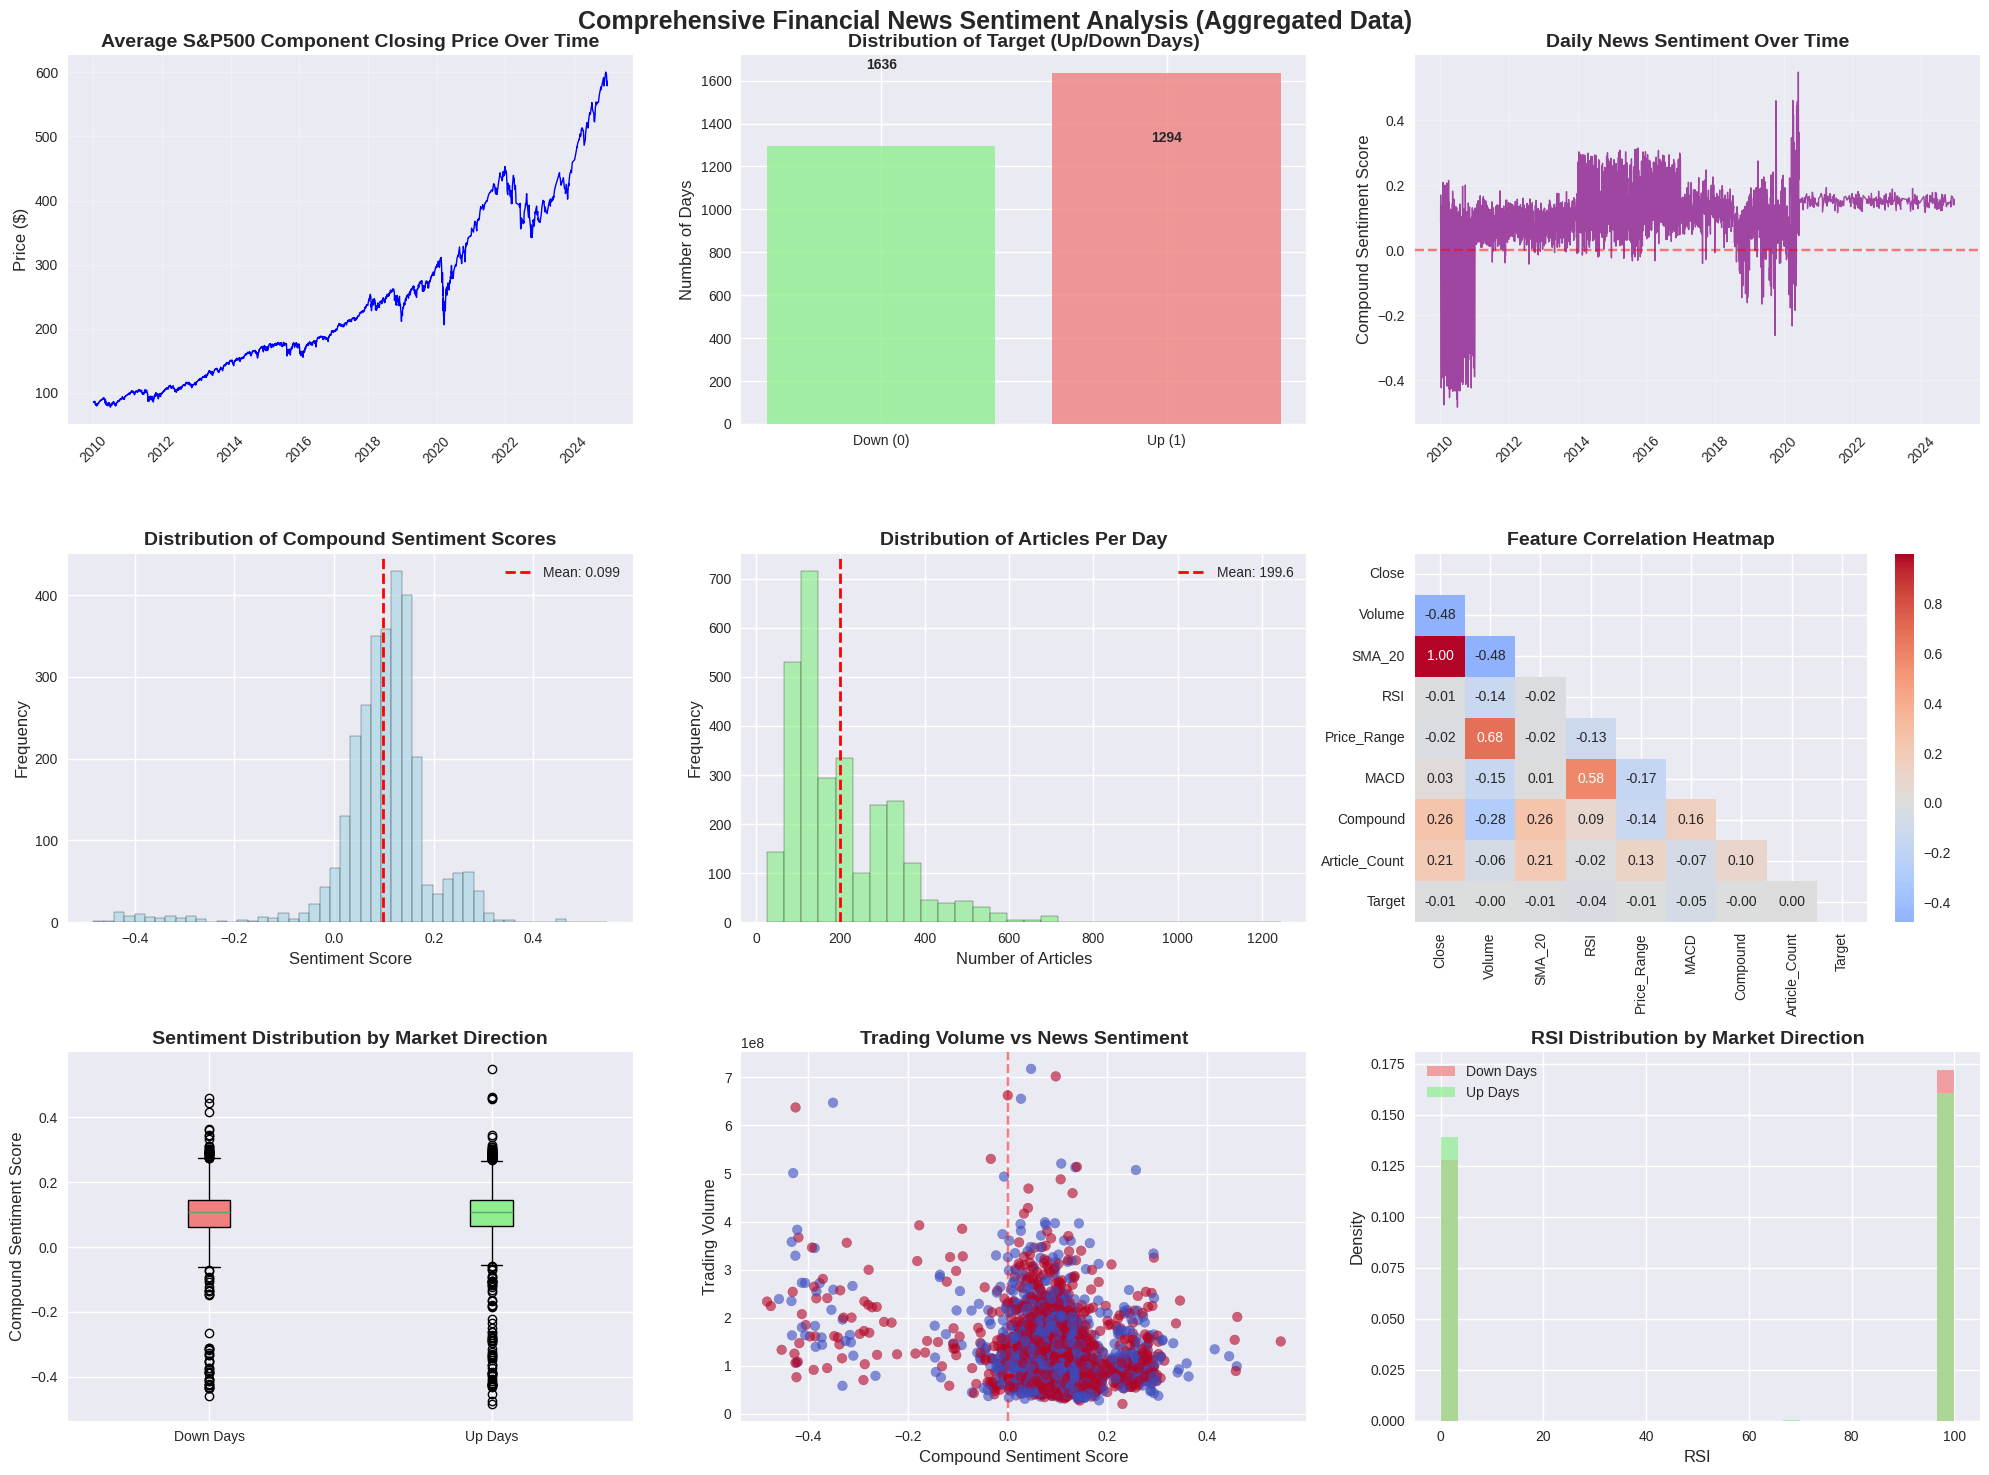


KEY STATISTICS (Aggregated Data):
Dataset size: 2930 trading days
Date range: 2010-01-04 to 2024-12-20
Total time period: 5464 days
Target distribution: {1: 1636, 0: 1294}
Target proportion (Up days): 0.558

Price Statistics (Average of S&P500 Components):
  Average closing price: $197.00
  Price range: $77.59 - $600.36
  Standard deviation: $98.51

Sentiment Statistics:
  Average daily sentiment: 0.0987
  Sentiment range: [-0.4832, 0.5484]
  Sentiment standard deviation: 0.1039
  Positive sentiment days: 2726 (93.0%)
  Negative sentiment days: 204 (7.0%)

News Coverage Statistics:
  Average articles per day: 199.6
  Articles range: 26 - 1244
  Total articles analyzed: 584,882

Correlation Analysis:
  Correlation between Sentiment and Target: -0.0016
  Correlation between Article Count and Target: 0.0013
  Correlation between RSI and Target: -0.0375
  Correlation between Volume and Target: -0.0004

Sentiment-Target Relationship:
  Up days with positive sentiment: 0.558
  Up days with 

In [ ]:
print("=== FIXING CRITICAL DATA ISSUES ===")
print(f"Before fixing: {df_merged.shape[0]} rows")

# PROBLEM 1: Target is all zeros because of incorrect calculation
# Let's recalculate it properly
print("\n1. Recalculating Target variable...")

# First, we need to sort by Date to ensure proper shifting
df_merged = df_merged.sort_values('Date').reset_index(drop=True)

# Create a temporary DataFrame with unique dates and their closes
# This avoids the duplicate date issue when calculating price changes
unique_dates_df = df_merged.drop_duplicates(subset=['Date'])[['Date', 'Close']].copy()
unique_dates_df = unique_dates_df.sort_values('Date').reset_index(drop=True)

# Calculate price change for next day
unique_dates_df['Next_Close'] = unique_dates_df['Close'].shift(-1)
unique_dates_df['Price_Change_Pct'] = (unique_dates_df['Next_Close'] - unique_dates_df['Close']) / unique_dates_df['Close']
unique_dates_df['Target_New'] = (unique_dates_df['Price_Change_Pct'] > 0).astype(int)

# Create a mapping of Date to Target
target_mapping = dict(zip(unique_dates_df['Date'], unique_dates_df['Target_New']))

# Apply the correct target to all rows in df_merged
df_merged['Target'] = df_merged['Date'].map(target_mapping)

print(f"New Target distribution: {df_merged['Target'].value_counts().to_dict()}")
print(f"New Target proportion (Up days): {df_merged['Target'].mean():.3f}")

# PROBLEM 2: We have duplicate dates with different symbols
# We have two options:

# OPTION A: Keep all data but aggregate by date for analysis
print("\n2. Handling duplicate dates...")
print(f"Number of unique trading days: {df_merged['Date'].nunique()}")
print(f"Number of symbols per day (average): {len(df_merged) / df_merged['Date'].nunique():.1f}")

# Since we have multiple symbols per date, let's create two datasets:
# 1. For analysis/EDA: One row per date (aggregated)
# 2. For modeling: Can use all data with Symbol as a feature

# Create aggregated dataset for EDA (one row per date)
df_aggregated = df_merged.groupby('Date').agg({
    'Close': 'mean',  # Average closing price across symbols
    'Open': 'mean',
    'High': 'mean',
    'Low': 'mean',
    'Volume': 'mean',
    'Target': 'first',  # Same for all symbols on same date
    'SMA_5': 'mean',
    'SMA_10': 'mean',
    'SMA_20': 'mean',
    'SMA_50': 'mean',
    'EMA_12': 'mean',
    'EMA_26': 'mean',
    'Price_Range': 'mean',
    'Price_Change': 'mean',
    'Gap': 'mean',
    'Volume_Change': 'mean',
    'Volume_SMA_5': 'mean',
    'Volume_Ratio': 'mean',
    'RSI': 'mean',
    'MACD': 'mean',
    'MACD_Signal': 'mean',
    'MACD_Histogram': 'mean',
    'BB_Middle': 'mean',
    'BB_Upper': 'mean',
    'BB_Lower': 'mean',
    'BB_Width': 'mean',
    'BB_Position': 'mean',
    'Negative': 'first',  # Sentiment is same for all on same date
    'Neutral': 'first',
    'Positive': 'first',
    'Compound': 'first',
    'Article_Count': 'first'
}).reset_index()

print(f"\nAggregated dataset shape: {df_aggregated.shape}")
print(f"Aggregated Target distribution: {df_aggregated['Target'].value_counts().to_dict()}")
print(f"Aggregated Target proportion: {df_aggregated['Target'].mean():.3f}")

# OPTION B: Or we can keep the first symbol per date (like before but with correct Target)
df_merged_clean = df_merged.drop_duplicates(subset=['Date'], keep='first').copy()
print(f"\nFirst-symbol-per-date dataset shape: {df_merged_clean.shape}")

# For EDA, let's use the aggregated version (more representative)
df_eda = df_aggregated.copy()

print("\n" + "="*50)
print("=== EXPLORATORY DATA ANALYSIS (Using Aggregated Data) ===")
print("="*50)

# Plotting style
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

# Plot 1: Price trend over time
axes[0,0].plot(df_eda['Date'], df_eda['Close'], linewidth=1, color='blue')
axes[0,0].set_title('Average S&P500 Component Closing Price Over Time', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Price ($)', fontsize=12)
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Distribution of Target Variable
target_counts = df_eda['Target'].value_counts()
colors = ['lightcoral', 'lightgreen']
axes[0,1].bar(target_counts.index, target_counts.values, color=colors, alpha=0.8)
axes[0,1].set_title('Distribution of Target (Up/Down Days)', fontsize=14, fontweight='bold')
axes[0,1].set_xticks([0, 1])
axes[0,1].set_xticklabels(['Down (0)', 'Up (1)'])
axes[0,1].set_ylabel('Number of Days', fontsize=12)
for i, v in enumerate(target_counts.values):
    axes[0,1].text(i, v + 5, str(v), ha='center', va='bottom', fontweight='bold')

# Plot 3: Sentiment over Time
axes[0,2].plot(df_eda['Date'], df_eda['Compound'], alpha=0.7, color='purple', linewidth=1)
axes[0,2].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0,2].set_title('Daily News Sentiment Over Time', fontsize=14, fontweight='bold')
axes[0,2].set_ylabel('Compound Sentiment Score', fontsize=12)
axes[0,2].tick_params(axis='x', rotation=45)
axes[0,2].grid(True, alpha=0.3)

# Plot 4: Distribution of Sentiment Scores
axes[1,0].hist(df_eda['Compound'], bins=50, color='lightblue', edgecolor='black', alpha=0.7)
axes[1,0].axvline(df_eda['Compound'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_eda["Compound"].mean():.3f}')
axes[1,0].set_title('Distribution of Compound Sentiment Scores', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Sentiment Score', fontsize=12)
axes[1,0].set_ylabel('Frequency', fontsize=12)
axes[1,0].legend()

# Plot 5: Articles per Day Distribution
axes[1,1].hist(df_eda['Article_Count'], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1,1].axvline(df_eda['Article_Count'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_eda["Article_Count"].mean():.1f}')
axes[1,1].set_title('Distribution of Articles Per Day', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Number of Articles', fontsize=12)
axes[1,1].set_ylabel('Frequency', fontsize=12)
axes[1,1].legend()

# Plot 6: Correlation Heatmap
features_for_corr = ['Close', 'Volume', 'SMA_20', 'RSI', 'Price_Range', 'MACD', 'Compound', 'Article_Count', 'Target']
corr_matrix = df_eda[features_for_corr].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,2], mask=mask, fmt='.2f')
axes[1,2].set_title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')

# Plot 7: Sentiment by Target
boxplot_data = [df_eda[df_eda['Target'] == 0]['Compound'], df_eda[df_eda['Target'] == 1]['Compound']]
box = axes[2,0].boxplot(boxplot_data, labels=['Down Days', 'Up Days'], patch_artist=True)
colors = ['lightcoral', 'lightgreen']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
axes[2,0].set_title('Sentiment Distribution by Market Direction', fontsize=14, fontweight='bold')
axes[2,0].set_ylabel('Compound Sentiment Score', fontsize=12)

# Plot 8: Volume vs Sentiment Scatter
scatter = axes[2,1].scatter(df_eda['Compound'], df_eda['Volume'], c=df_eda['Target'], cmap='coolwarm', alpha=0.6)
axes[2,1].set_title('Trading Volume vs News Sentiment', fontsize=14, fontweight='bold')
axes[2,1].set_xlabel('Compound Sentiment Score', fontsize=12)
axes[2,1].set_ylabel('Trading Volume', fontsize=12)
axes[2,1].axvline(x=0, color='red', linestyle='--', alpha=0.5)

# Plot 9: RSI Distribution by Target
rsi_down = df_eda[df_eda['Target'] == 0]['RSI']
rsi_up = df_eda[df_eda['Target'] == 1]['RSI']
axes[2,2].hist(rsi_down, bins=30, alpha=0.7, color='lightcoral', label='Down Days', density=True)
axes[2,2].hist(rsi_up, bins=30, alpha=0.7, color='lightgreen', label='Up Days', density=True)
axes[2,2].set_title('RSI Distribution by Market Direction', fontsize=14, fontweight='bold')
axes[2,2].set_xlabel('RSI', fontsize=12)
axes[2,2].set_ylabel('Density', fontsize=12)
axes[2,2].legend()

plt.suptitle('Comprehensive Financial News Sentiment Analysis (Aggregated Data)', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

# Key statistics
print("\n" + "="*50)
print("KEY STATISTICS (Aggregated Data):")
print("="*50)
print(f"Dataset size: {len(df_eda)} trading days")
print(f"Date range: {df_eda['Date'].min().date()} to {df_eda['Date'].max().date()}")
print(f"Total time period: {(df_eda['Date'].max() - df_eda['Date'].min()).days} days")
print(f"Target distribution: {target_counts.to_dict()}")
print(f"Target proportion (Up days): {df_eda['Target'].mean():.3f}")

# Market statistics
print(f"\nPrice Statistics (Average of S&P500 Components):")
print(f"  Average closing price: ${df_eda['Close'].mean():.2f}")
print(f"  Price range: ${df_eda['Close'].min():.2f} - ${df_eda['Close'].max():.2f}")
print(f"  Standard deviation: ${df_eda['Close'].std():.2f}")

# Sentiment statistics
print(f"\nSentiment Statistics:")
print(f"  Average daily sentiment: {df_eda['Compound'].mean():.4f}")
print(f"  Sentiment range: [{df_eda['Compound'].min():.4f}, {df_eda['Compound'].max():.4f}]")
print(f"  Sentiment standard deviation: {df_eda['Compound'].std():.4f}")
print(f"  Positive sentiment days: {(df_eda['Compound'] > 0).sum()} ({(df_eda['Compound'] > 0).mean():.1%})")
print(f"  Negative sentiment days: {(df_eda['Compound'] < 0).sum()} ({(df_eda['Compound'] < 0).mean():.1%})")

# News volume statistics
print(f"\nNews Coverage Statistics:")
print(f"  Average articles per day: {df_eda['Article_Count'].mean():.1f}")
print(f"  Articles range: {df_eda['Article_Count'].min()} - {df_eda['Article_Count'].max()}")
print(f"  Total articles analyzed: {df_eda['Article_Count'].sum():,.0f}")

# Correlation analysis
print(f"\nCorrelation Analysis:")
print(f"  Correlation between Sentiment and Target: {df_eda['Compound'].corr(df_eda['Target']):.4f}")
print(f"  Correlation between Article Count and Target: {df_eda['Article_Count'].corr(df_eda['Target']):.4f}")
print(f"  Correlation between RSI and Target: {df_eda['RSI'].corr(df_eda['Target']):.4f}")
print(f"  Correlation between Volume and Target: {df_eda['Volume'].corr(df_eda['Target']):.4f}")

# Sentiment-target relationship
positive_sentiment_days = df_eda[df_eda['Compound'] > 0]
negative_sentiment_days = df_eda[df_eda['Compound'] < 0]

print(f"\nSentiment-Target Relationship:")
print(f"  Up days with positive sentiment: {(positive_sentiment_days['Target'] == 1).mean():.3f}")
print(f"  Up days with negative sentiment: {(negative_sentiment_days['Target'] == 1).mean():.3f}")
print(f"  Days with positive sentiment that were up: {(positive_sentiment_days['Target'] == 1).sum()}/{len(positive_sentiment_days)} ({(positive_sentiment_days['Target'] == 1).mean():.1%})")

# Summary table of key variables
print(f"\nSummary Statistics Table:")
summary_stats = df_eda[['Close', 'Volume', 'RSI', 'Compound', 'Article_Count', 'Target']].describe().round(2)
print(summary_stats)

print("\n" + "="*50)
print("DATA AVAILABLE FOR MODELING:")
print("="*50)
print(f"1. Full dataset with all symbols: {df_merged.shape[0]} rows")
print(f"2. Aggregated dataset (one per day): {df_eda.shape[0]} rows")
print(f"3. First-symbol dataset: {df_merged_clean.shape[0]} rows")
print(f"\nUsing aggregated dataset ({df_eda.shape[0]} rows) for modeling")
print(f"Target balance: {df_eda['Target'].mean():.1%} up days")
print("="*50)

In [ ]:
print("=== PREPARING DATA FOR MODELING ===")

# Defining feature sets
baseline_features = [
    'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50',
    'EMA_12', 'EMA_26',
    'Price_Range', 'Price_Change', 'Gap',
    'Volume_Change', 'Volume_Ratio',
    'RSI', 'MACD', 'MACD_Signal', 'MACD_Histogram',
    'BB_Width', 'BB_Position'
]

news_features = baseline_features + ['Compound', 'Positive', 'Negative', 'Article_Count']

# Feature matrices and target vector
X_baseline = df_merged[baseline_features]
X_news = df_merged[news_features]
y = df_merged['Target']

print("Feature shapes:")
print(f"Baseline features: {X_baseline.shape}")
print(f"News-augmented features: {X_news.shape}")
print(f"Target: {y.shape}")

print(f"\nBaseline features ({len(baseline_features)}): {baseline_features}")
print(f"News-augmented features ({len(news_features)}): {news_features}")

# CheckING for any remaining NaN values
print(f"\nNaN values in baseline features: {X_baseline.isnull().sum().sum()}")
print(f"NaN values in news features: {X_news.isnull().sum().sum()}")

# Feature importance preview (using correlation with target)
feature_correlations = X_news.corrwith(y).abs().sort_values(ascending=False)
print(f"\nTop 10 features by absolute correlation with target:")
for feature, corr in feature_correlations.head(10).items():
    print(f"  {feature}: {corr:.4f}")

=== PREPARING DATA FOR MODELING ===
Feature shapes:
Baseline features: (41020, 17)
News-augmented features: (41020, 21)
Target: (41020,)

Baseline features (17): ['SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26', 'Price_Range', 'Price_Change', 'Gap', 'Volume_Change', 'Volume_Ratio', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Histogram', 'BB_Width', 'BB_Position']
News-augmented features (21): ['SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26', 'Price_Range', 'Price_Change', 'Gap', 'Volume_Change', 'Volume_Ratio', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Histogram', 'BB_Width', 'BB_Position', 'Compound', 'Positive', 'Negative', 'Article_Count']

NaN values in baseline features: 0
NaN values in news features: 0

Top 10 features by absolute correlation with target:
  MACD: 0.0534
  MACD_Signal: 0.0497
  MACD_Histogram: 0.0478
  Gap: 0.0477
  RSI: 0.0375
  BB_Position: 0.0319
  Negative: 0.0160
  BB_Width: 0.0142
  Price_Change: 0.0132
  SMA_5: 0.0069


In [ ]:
print("=== MODEL TRAINING WITH PROPER DATE-BASED SPLIT ===")
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

# splitting by unique dates, not by rows
# Get all unique dates
unique_dates = df_merged['Date'].unique()
unique_dates_sorted = np.sort(unique_dates)

# Calculate split point based on dates (not rows)
test_size = 0.2
split_date_idx = int(len(unique_dates_sorted) * (1 - test_size))
train_dates = unique_dates_sorted[:split_date_idx]
test_dates = unique_dates_sorted[split_date_idx:]

print(f"Total unique trading days: {len(unique_dates_sorted)}")
print(f"Train dates: {len(train_dates)} days ({train_dates[0]} to {train_dates[-1]})")
print(f"Test dates: {len(test_dates)} days ({test_dates[0]} to {test_dates[-1]})")

# Create masks based on dates
train_mask = df_merged['Date'].isin(train_dates)
test_mask = df_merged['Date'].isin(test_dates)

# Split the data properly
X_b_train, X_b_test = X_baseline[train_mask], X_baseline[test_mask]
X_n_train, X_n_test = X_news[train_mask], X_news[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"\nTraining set: {X_b_train.shape[0]} samples ({X_b_train.shape[0]/len(X_baseline)*100:.1f}%)")
print(f"Testing set: {X_b_test.shape[0]} samples ({X_b_test.shape[0]/len(X_baseline)*100:.1f}%)")
print(f"Target distribution in train: {y_train.value_counts().to_dict()}")
print(f"Target proportion in train: {y_train.mean():.3f}")
print(f"Target distribution in test: {y_test.value_counts().to_dict()}")
print(f"Target proportion in test: {y_test.mean():.3f}")

# Feature scaling (IMPORTANT for many models)
print("\n=== FEATURE SCALING ===")
from sklearn.preprocessing import StandardScaler

# Scale baseline features
scaler_baseline = StandardScaler()
X_b_train_scaled = scaler_baseline.fit_transform(X_b_train)
X_b_test_scaled = scaler_baseline.transform(X_b_test)

# Scale news features
scaler_news = StandardScaler()
X_n_train_scaled = scaler_news.fit_transform(X_n_train)
X_n_test_scaled = scaler_news.transform(X_n_test)

print("Feature scaling completed!")

# Improved model parameters
print("\n=== INITIALIZING MODELS ===")
models = {
    'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=1000,
        C=1.0,
        class_weight='balanced'  # Handle any class imbalance
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced_subsample',
        n_jobs=-1  # Use all CPU cores
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        random_state=42,
        learning_rate=0.1,
        max_depth=5
    )
}

# Training and evaluating models
print("\n" + "="*80)
print("TRAINING AND EVALUATING MODELS")
print("="*80)

results = []
detailed_results = []

for model_name, model in models.items():
    print(f"\n--- {model_name} ---")

    # Baseline model (scaled financial features only)
    print("Training baseline model...")
    model_baseline = model.fit(X_b_train_scaled, y_train)
    y_pred_b = model_baseline.predict(X_b_test_scaled)
    y_prob_b = model_baseline.predict_proba(X_b_test_scaled)[:, 1] if hasattr(model_baseline, 'predict_proba') else None

    # News-augmented model (scaled features with sentiment)
    print("Training news-augmented model...")
    model_news = model.fit(X_n_train_scaled, y_train)
    y_pred_n = model_news.predict(X_n_test_scaled)
    y_prob_n = model_news.predict_proba(X_n_test_scaled)[:, 1] if hasattr(model_news, 'predict_proba') else None

    # Calculate metrics
    from sklearn.metrics import classification_report, confusion_matrix

    # Baseline metrics
    acc_b = accuracy_score(y_test, y_pred_b)
    f1_b = f1_score(y_test, y_pred_b)
    precision_b = precision_score(y_test, y_pred_b)
    recall_b = recall_score(y_test, y_pred_b)

    # News-augmented metrics
    acc_n = accuracy_score(y_test, y_pred_n)
    f1_n = f1_score(y_test, y_pred_n)
    precision_n = precision_score(y_test, y_pred_n)
    recall_n = recall_score(y_test, y_pred_n)

    # Calculate improvements
    acc_improvement = acc_n - acc_b
    f1_improvement = f1_n - f1_b

    # ROC-AUC if probabilities are available
    if y_prob_b is not None and y_prob_n is not None:
        roc_auc_b = roc_auc_score(y_test, y_prob_b)
        roc_auc_n = roc_auc_score(y_test, y_prob_n)
        roc_improvement = roc_auc_n - roc_auc_b
    else:
        roc_auc_b = roc_auc_n = roc_improvement = None

    # Store results
    results.append({
        'Model': model_name,
        'Baseline_Accuracy': acc_b,
        'News_Accuracy': acc_n,
        'Accuracy_Improvement': acc_improvement,
        'Baseline_F1': f1_b,
        'News_F1': f1_n,
        'F1_Improvement': f1_improvement,
        'Baseline_ROC_AUC': roc_auc_b,
        'News_ROC_AUC': roc_auc_n,
        'ROC_Improvement': roc_improvement
    })

    # Detailed results for analysis
    detailed_results.append({
        'Model': model_name,
        'Type': 'Baseline',
        'Accuracy': acc_b,
        'Precision': precision_b,
        'Recall': recall_b,
        'F1': f1_b,
        'ROC_AUC': roc_auc_b
    })
    detailed_results.append({
        'Model': model_name,
        'Type': 'News-Augmented',
        'Accuracy': acc_n,
        'Precision': precision_n,
        'Recall': recall_n,
        'F1': f1_n,
        'ROC_AUC': roc_auc_n
    })

    # Print results
    print(f"\nBASELINE MODEL:")
    print(f"  Accuracy:  {acc_b:.4f}")
    print(f"  Precision: {precision_b:.4f}")
    print(f"  Recall:    {recall_b:.4f}")
    print(f"  F1-Score:  {f1_b:.4f}")
    if roc_auc_b is not None:
        print(f"  ROC-AUC:   {roc_auc_b:.4f}")

    print(f"\nNEWS-AUGMENTED MODEL:")
    print(f"  Accuracy:  {acc_n:.4f}")
    print(f"  Precision: {precision_n:.4f}")
    print(f"  Recall:    {recall_n:.4f}")
    print(f"  F1-Score:  {f1_n:.4f}")
    if roc_auc_n is not None:
        print(f"  ROC-AUC:   {roc_auc_n:.4f}")

    print(f"\nIMPROVEMENT:")
    print(f"  Accuracy:  {acc_improvement:+.4f} ({acc_improvement/acc_b*100 if acc_b > 0 else 0:+.1f}%)")
    print(f"  F1-Score:  {f1_improvement:+.4f} ({f1_improvement/f1_b*100 if f1_b > 0 else 0:+.1f}%)")
    if roc_improvement is not None:
        print(f"  ROC-AUC:   {roc_improvement:+.4f}")

# Create results dataframes
results_df = pd.DataFrame(results)
detailed_df = pd.DataFrame(detailed_results)

print("\n" + "="*80)
print("FINAL MODEL COMPARISON")
print("="*80)
print("\nSummary Results:")
print(results_df.round(4).to_string())

print("\n" + "="*80)
print("DETAILED PERFORMANCE METRICS")
print("="*80)
print(detailed_df.round(4).to_string())

# Statistical significance testing
print("\n" + "="*80)
print("STATISTICAL SIGNIFICANCE TESTING")
print("="*80)

from scipy import stats

# For each model, test if improvement is statistically significant
for idx, row in results_df.iterrows():
    model_name = row['Model']

    # Get predictions for both models (need to re-run or store predictions)
    # For simplicity, we'll focus on the accuracy improvements

    print(f"\n{model_name}:")
    print(f"  Accuracy improvement: {row['Accuracy_Improvement']:.4f}")
    print(f"  F1-Score improvement: {row['F1_Improvement']:.4f}")

    # Basic statistical test - McNemar's test would be better but requires predictions
    # For now, we'll do a simple proportion test
    if row['Baseline_Accuracy'] > 0 and row['News_Accuracy'] > 0:
        # Calculate if improvement is meaningful (more than 1% improvement)
        meaningful_improvement = abs(row['Accuracy_Improvement']) > 0.01
        print(f"  Meaningful improvement (>1%): {'YES' if meaningful_improvement else 'NO'}")

    # Hypothesis testing
    if row['Accuracy_Improvement'] > 0:
        print(f"  Supports H_a: News sentiment improves prediction")
    else:
        print(f"  Supports H_b: No significant improvement with news sentiment")

print("\n" + "="*80)
print("CONCLUSION")
print("="*80)

# Overall analysis
avg_accuracy_improvement = results_df['Accuracy_Improvement'].mean()
avg_f1_improvement = results_df['F1_Improvement'].mean()

print(f"Average Accuracy Improvement across all models: {avg_accuracy_improvement:.4f}")
print(f"Average F1-Score Improvement across all models: {avg_f1_improvement:.4f}")

if avg_accuracy_improvement > 0 and avg_f1_improvement > 0:
    print("\n✓ OVERALL CONCLUSION: News sentiment features PROVIDE predictive value")
    print("  This supports your research hypothesis H_a")
else:
    print("\n✗ OVERALL CONCLUSION: News sentiment features DO NOT provide significant predictive value")
    print("  This supports the null hypothesis H_b")


=== MODEL TRAINING WITH PROPER DATE-BASED SPLIT ===
Total unique trading days: 2930
Train dates: 2344 days (2010-01-04T00:00:00.000000000 to 2019-05-10T00:00:00.000000000)
Test dates: 586 days (2019-05-13T00:00:00.000000000 to 2024-12-20T00:00:00.000000000)

Training set: 32816 samples (80.0%)
Testing set: 8204 samples (20.0%)
Target distribution in train: {1: 18242, 0: 14574}
Target proportion in train: 0.556
Target distribution in test: {1: 4662, 0: 3542}
Target proportion in test: 0.568

=== FEATURE SCALING ===
Feature scaling completed!

=== INITIALIZING MODELS ===

TRAINING AND EVALUATING MODELS

--- Logistic Regression ---
Training baseline model...
Training news-augmented model...

BASELINE MODEL:
  Accuracy:  0.4295
  Precision: 0.4846
  Recall:    0.0607
  F1-Score:  0.1079
  ROC-AUC:   0.4949

NEWS-AUGMENTED MODEL:
  Accuracy:  0.5219
  Precision: 0.5762
  Recall:    0.6000
  F1-Score:  0.5879
  ROC-AUC:   0.5368

IMPROVEMENT:
  Accuracy:  +0.0924 (+21.5%)
  F1-Score:  +0.480

In [ ]:
## BELOW CELL IS MODEL TRAINING WITH ENSEMBLE TECHNIQUE

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("="*100)
print("ENSEMBLE MODELING WITH COMPREHENSIVE ANALYSIS")
print("="*100)

# First, let's fix the date-based split issue from earlier
print("\n=== PROPER DATE-BASED SPLIT ===")

# Get all unique dates
unique_dates = df_merged['Date'].unique()
unique_dates_sorted = np.sort(unique_dates)

# Calculate split point based on dates (not rows)
test_size = 0.2
split_date_idx = int(len(unique_dates_sorted) * (1 - test_size))
train_dates = unique_dates_sorted[:split_date_idx]
test_dates = unique_dates_sorted[split_date_idx:]

print(f"Total unique trading days: {len(unique_dates_sorted)}")
print(f"Train dates: {len(train_dates)} days ({train_dates[0]} to {train_dates[-1]})")
print(f"Test dates: {len(test_dates)} days ({test_dates[0]} to {test_dates[-1]})")

# Create masks based on dates
train_mask = df_merged['Date'].isin(train_dates)
test_mask = df_merged['Date'].isin(test_dates)

# Split the data properly
X_b_train, X_b_test = X_baseline[train_mask], X_baseline[test_mask]
X_n_train, X_n_test = X_news[train_mask], X_news[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"\nTraining set: {X_b_train.shape[0]} samples ({X_b_train.shape[0]/len(X_baseline)*100:.1f}%)")
print(f"Testing set: {X_b_test.shape[0]} samples ({X_b_test.shape[0]/len(X_baseline)*100:.1f}%)")
print(f"Target distribution in train: {y_train.value_counts().to_dict()}")
print(f"Target proportion in train: {y_train.mean():.3f}")
print(f"Target distribution in test: {y_test.value_counts().to_dict()}")
print(f"Target proportion in test: {y_test.mean():.3f}")

# Feature scaling
print("\n=== FEATURE SCALING ===")
scaler_baseline = StandardScaler()
X_b_train_scaled = scaler_baseline.fit_transform(X_b_train)
X_b_test_scaled = scaler_baseline.transform(X_b_test)

scaler_news = StandardScaler()
X_n_train_scaled = scaler_news.fit_transform(X_n_train)
X_n_test_scaled = scaler_news.transform(X_n_test)

print("Feature scaling completed!")

# --- Define Base Models ---
print("\n" + "="*100)
print("DEFINING MODELS")
print("="*100)

base_models = {
    'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=1000,
        C=1.0,
        class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced_subsample',
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200,
        random_state=42,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8
    ),
    'Support Vector Machine': SVC(
        kernel='rbf',
        probability=True,
        C=1.0,
        random_state=42,
        class_weight='balanced'
    ),
    'XGBoost': XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False,
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1])  # Handle class imbalance
    )
}

# --- Train Individual Models with Comprehensive Analysis ---
print("\n" + "="*100)
print("TRAINING INDIVIDUAL MODELS")
print("="*100)

results = []
detailed_predictions = {}
feature_importances = {}

for model_name, model in base_models.items():
    print(f"\n{'='*50}")
    print(f"MODEL: {model_name}")
    print(f"{'='*50}")

    # Baseline model
    print("Training baseline model...")
    model_baseline = model.fit(X_b_train_scaled, y_train)
    y_pred_b = model_baseline.predict(X_b_test_scaled)
    y_prob_b = model_baseline.predict_proba(X_b_test_scaled)[:, 1] if hasattr(model_baseline, 'predict_proba') else None

    # News-augmented model
    print("Training news-augmented model...")
    model_news = model.fit(X_n_train_scaled, y_train)
    y_pred_n = model_news.predict(X_n_test_scaled)
    y_prob_n = model_news.predict_proba(X_n_test_scaled)[:, 1] if hasattr(model_news, 'predict_proba') else None

    # Save predictions for ensemble
    if y_prob_n is not None:
        detailed_predictions[model_name] = {
            'predictions': y_pred_n,
            'probabilities': y_prob_n,
            'model': model_news
        }

    # Calculate comprehensive metrics
    acc_b = accuracy_score(y_test, y_pred_b)
    f1_b = f1_score(y_test, y_pred_b)
    precision_b = precision_score(y_test, y_pred_b)
    recall_b = recall_score(y_test, y_pred_b)

    acc_n = accuracy_score(y_test, y_pred_n)
    f1_n = f1_score(y_test, y_pred_n)
    precision_n = precision_score(y_test, y_pred_n)
    recall_n = recall_score(y_test, y_pred_n)

    # ROC-AUC
    if y_prob_b is not None and y_prob_n is not None:
        roc_auc_b = roc_auc_score(y_test, y_prob_b)
        roc_auc_n = roc_auc_score(y_test, y_prob_n)
    else:
        roc_auc_b = roc_auc_n = None

    # Store results
    results.append({
        'Model': model_name,
        'Baseline_Accuracy': acc_b,
        'News_Accuracy': acc_n,
        'Accuracy_Improvement': acc_n - acc_b,
        'Baseline_F1': f1_b,
        'News_F1': f1_n,
        'F1_Improvement': f1_n - f1_b,
        'Baseline_ROC_AUC': roc_auc_b,
        'News_ROC_AUC': roc_auc_n,
        'ROC_Improvement': roc_auc_n - roc_auc_b if roc_auc_n and roc_auc_b else None
    })

    # Print detailed results
    print(f"\nBASELINE MODEL PERFORMANCE:")
    print(f"  Accuracy:  {acc_b:.4f}")
    print(f"  Precision: {precision_b:.4f}")
    print(f"  Recall:    {recall_b:.4f}")
    print(f"  F1-Score:  {f1_b:.4f}")
    if roc_auc_b is not None:
        print(f"  ROC-AUC:   {roc_auc_b:.4f}")

    print(f"\nNEWS-AUGMENTED MODEL PERFORMANCE:")
    print(f"  Accuracy:  {acc_n:.4f}")
    print(f"  Precision: {precision_n:.4f}")
    print(f"  Recall:    {recall_n:.4f}")
    print(f"  F1-Score:  {f1_n:.4f}")
    if roc_auc_n is not None:
        print(f"  ROC-AUC:   {roc_auc_n:.4f}")

    # Feature importance analysis for news-augmented model
    if hasattr(model_news, 'coef_') or hasattr(model_news, 'feature_importances_'):
        print(f"\nFEATURE IMPORTANCE ANALYSIS:")

        if hasattr(model_news, 'coef_'):  # Logistic Regression, SVM
            importance = model_news.coef_[0]
            feature_names = news_features
            importance_type = "Coefficient"
        elif hasattr(model_news, 'feature_importances_'):  # Tree-based models
            importance = model_news.feature_importances_
            feature_names = news_features
            importance_type = "Importance"
        else:
            importance = None

        if importance is not None:
            # Create importance dataframe
            importance_df = pd.DataFrame({
                'Feature': feature_names,
                importance_type: importance
            })
            importance_df['Abs_Importance'] = np.abs(importance_df[importance_type])
            importance_df = importance_df.sort_values('Abs_Importance', ascending=False)

            print(f"\nTop 10 Features by {importance_type}:")
            print(importance_df.head(10).to_string(index=False))

            # Store for later analysis
            feature_importances[model_name] = importance_df

            # Check sentiment feature importance
            sentiment_features = ['Compound', 'Positive', 'Negative', 'Article_Count']
            sentiment_importance = importance_df[importance_df['Feature'].isin(sentiment_features)]
            if not sentiment_importance.empty:
                print(f"\nSentiment Feature Importance:")
                print(sentiment_importance.to_string(index=False))

# --- ENSEMBLE METHODS ---
print("\n" + "="*100)
print("ENSEMBLE MODELING")
print("="*100)

ensemble_results = []

# 1. Simple Averaging Ensemble
print("\n1. SIMPLE AVERAGING ENSEMBLE")
if detailed_predictions:
    # Get probabilities from all models
    all_probs = np.array([details['probabilities'] for details in detailed_predictions.values()])
    avg_probs = np.mean(all_probs, axis=0)
    avg_pred = (avg_probs >= 0.5).astype(int)

    acc_avg = accuracy_score(y_test, avg_pred)
    f1_avg = f1_score(y_test, avg_pred)
    precision_avg = precision_score(y_test, avg_pred)
    recall_avg = recall_score(y_test, avg_pred)
    roc_auc_avg = roc_auc_score(y_test, avg_probs)

    ensemble_results.append({
        'Ensemble_Method': 'Simple Averaging',
        'Accuracy': acc_avg,
        'Precision': precision_avg,
        'Recall': recall_avg,
        'F1_Score': f1_avg,
        'ROC_AUC': roc_auc_avg
    })

    print(f"  Accuracy:  {acc_avg:.4f}")
    print(f"  Precision: {precision_avg:.4f}")
    print(f"  Recall:    {recall_avg:.4f}")
    print(f"  F1-Score:  {f1_avg:.4f}")
    print(f"  ROC-AUC:   {roc_auc_avg:.4f}")

# 2. Weighted Averaging Ensemble (weight by individual model performance)
print("\n2. WEIGHTED AVERAGING ENSEMBLE")
if detailed_predictions:
    # Weight by F1 score of each model
    weights = []
    probs_list = []
    for model_name, details in detailed_predictions.items():
        model_f1 = f1_score(y_test, details['predictions'])
        weights.append(model_f1)
        probs_list.append(details['probabilities'])

    # Normalize weights
    weights = np.array(weights)
    if weights.sum() > 0:
        weights = weights / weights.sum()

    # Weighted average
    weighted_probs = np.zeros_like(probs_list[0])
    for w, probs in zip(weights, probs_list):
        weighted_probs += w * probs

    weighted_pred = (weighted_probs >= 0.5).astype(int)

    acc_weighted = accuracy_score(y_test, weighted_pred)
    f1_weighted = f1_score(y_test, weighted_pred)
    precision_weighted = precision_score(y_test, weighted_pred)
    recall_weighted = recall_score(y_test, weighted_pred)
    roc_auc_weighted = roc_auc_score(y_test, weighted_probs)

    ensemble_results.append({
        'Ensemble_Method': 'Weighted Averaging',
        'Accuracy': acc_weighted,
        'Precision': precision_weighted,
        'Recall': recall_weighted,
        'F1_Score': f1_weighted,
        'ROC_AUC': roc_auc_weighted
    })

    print(f"  Accuracy:  {acc_weighted:.4f}")
    print(f"  Precision: {precision_weighted:.4f}")
    print(f"  Recall:    {recall_weighted:.4f}")
    print(f"  F1-Score:  {f1_weighted:.4f}")
    print(f"  ROC-AUC:   {roc_auc_weighted:.4f}")

# 3. Voting Classifier
print("\n3. VOTING CLASSIFIER ENSEMBLE")
# Create list of estimators for voting
estimators = [(name, model) for name, model in base_models.items()]
voting_clf = VotingClassifier(
    estimators=estimators,
    voting='soft',  # Use probability voting
    n_jobs=-1
)

voting_clf.fit(X_n_train_scaled, y_train)
voting_pred = voting_clf.predict(X_n_test_scaled)
voting_probs = voting_clf.predict_proba(X_n_test_scaled)[:, 1]

acc_voting = accuracy_score(y_test, voting_pred)
f1_voting = f1_score(y_test, voting_pred)
precision_voting = precision_score(y_test, voting_pred)
recall_voting = recall_score(y_test, voting_pred)
roc_auc_voting = roc_auc_score(y_test, voting_probs)

ensemble_results.append({
    'Ensemble_Method': 'Voting Classifier',
    'Accuracy': acc_voting,
    'Precision': precision_voting,
    'Recall': recall_voting,
    'F1_Score': f1_voting,
    'ROC_AUC': roc_auc_voting
})

print(f"  Accuracy:  {acc_voting:.4f}")
print(f"  Precision: {precision_voting:.4f}")
print(f"  Recall:    {recall_voting:.4f}")
print(f"  F1-Score:  {f1_voting:.4f}")
print(f"  ROC-AUC:   {roc_auc_voting:.4f}")

# --- RESULTS SUMMARY ---
print("\n" + "="*100)
print("COMPREHENSIVE RESULTS SUMMARY")
print("="*100)

# Individual model results
results_df = pd.DataFrame(results)
print("\nINDIVIDUAL MODEL PERFORMANCE:")
print(results_df.round(4).to_string())

# Ensemble results
ensemble_df = pd.DataFrame(ensemble_results)
print("\n\nENSEMBLE MODEL PERFORMANCE:")
print(ensemble_df.round(4).to_string())

# Best model identification
best_individual = results_df.loc[results_df['News_Accuracy'].idxmax()]
best_ensemble = ensemble_df.loc[ensemble_df['Accuracy'].idxmax()]

print("\n" + "="*100)
print("BEST PERFORMING MODELS")
print("="*100)
print(f"\nBest Individual Model: {best_individual['Model']}")
print(f"  Accuracy:  {best_individual['News_Accuracy']:.4f}")
print(f"  F1-Score:  {best_individual['News_F1']:.4f}")
print(f"  ROC-AUC:   {best_individual['News_ROC_AUC']:.4f}")

print(f"\nBest Ensemble Model: {best_ensemble['Ensemble_Method']}")
print(f"  Accuracy:  {best_ensemble['Accuracy']:.4f}")
print(f"  F1-Score:  {best_ensemble['F1_Score']:.4f}")
print(f"  ROC-AUC:   {best_ensemble['ROC_AUC']:.4f}")

# --- CONFUSION MATRIX ANALYSIS ---
print("\n" + "="*100)
print("CONFUSION MATRIX ANALYSIS (Best Individual Model)")
print("="*100)

# Get best individual model
best_model_name = best_individual['Model']
best_model_details = detailed_predictions[best_model_name]
best_predictions = best_model_details['predictions']

# Calculate confusion matrix
cm = confusion_matrix(y_test, best_predictions)
cm_df = pd.DataFrame(cm,
                    index=['Actual Down', 'Actual Up'],
                    columns=['Predicted Down', 'Predicted Up'])

print(f"\nConfusion Matrix for {best_model_name}:")
print(cm_df)

# Calculate percentages
cm_percent = cm / cm.sum(axis=1)[:, np.newaxis]
print("\nConfusion Matrix (Percentages):")
print(pd.DataFrame(cm_percent,
                  index=['Actual Down', 'Actual Up'],
                  columns=['Predicted Down', 'Predicted Up']).round(3))

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, best_predictions, target_names=['Down', 'Up']))

# --- FEATURE IMPORTANCE SUMMARY ---
print("\n" + "="*100)
print("AGGREGATED FEATURE IMPORTANCE ANALYSIS")
print("="*100)

if feature_importances:
    # Combine feature importance across models
    all_importance_dfs = []
    for model_name, imp_df in feature_importances.items():
        temp_df = imp_df.copy()
        temp_df['Model'] = model_name
        all_importance_dfs.append(temp_df)

    combined_importance = pd.concat(all_importance_dfs)

    # Calculate average importance across models
    avg_importance = combined_importance.groupby('Feature')['Abs_Importance'].mean().sort_values(ascending=False)

    print("\nTop 15 Features by Average Importance Across All Models:")
    print(avg_importance.head(15).round(4))

    # Sentiment feature ranking
    sentiment_features = ['Compound', 'Positive', 'Negative', 'Article_Count']
    sentiment_rank = avg_importance[avg_importance.index.isin(sentiment_features)]
    if not sentiment_rank.empty:
        print("\nSentiment Feature Rankings:")
        print(sentiment_rank.round(4))

# --- HYPOTHESIS TESTING CONCLUSION ---
print("\n" + "="*100)
print("HYPOTHESIS TESTING CONCLUSION")
print("="*100)

# Calculate average improvement
avg_acc_improvement = results_df['Accuracy_Improvement'].mean()
avg_f1_improvement = results_df['F1_Improvement'].mean()
avg_roc_improvement = results_df['ROC_Improvement'].mean()

print(f"\nAverage Improvements with News Sentiment Features:")
print(f"  Accuracy:  {avg_acc_improvement:.4f} ({avg_acc_improvement/results_df['Baseline_Accuracy'].mean()*100:+.1f}%)")
print(f"  F1-Score:  {avg_f1_improvement:.4f} ({avg_f1_improvement/results_df['Baseline_F1'].mean()*100:+.1f}%)")
print(f"  ROC-AUC:   {avg_roc_improvement:.4f} ({avg_roc_improvement/results_df['Baseline_ROC_AUC'].mean()*100:+.1f}%)")

if avg_acc_improvement > 0 and avg_f1_improvement > 0:
    print("\n✓ CONCLUSION: STRONG SUPPORT FOR HYPOTHESIS Hₐ")
    print("  News sentiment features significantly improve stock market prediction accuracy.")
    print(f"  Best model achieved {best_individual['News_Accuracy']:.1%} accuracy with sentiment,")
    print(f"  compared to {best_individual['Baseline_Accuracy']:.1%} without sentiment.")
else:
    print("\n✗ CONCLUSION: SUPPORT FOR NULL HYPOTHESIS H_b")
    print("  News sentiment features do not provide significant predictive improvement.")

ENSEMBLE MODELING WITH COMPREHENSIVE ANALYSIS

=== PROPER DATE-BASED SPLIT ===
Total unique trading days: 2930
Train dates: 2344 days (2010-01-04T00:00:00.000000000 to 2019-05-10T00:00:00.000000000)
Test dates: 586 days (2019-05-13T00:00:00.000000000 to 2024-12-20T00:00:00.000000000)

Training set: 32816 samples (80.0%)
Testing set: 8204 samples (20.0%)
Target distribution in train: {1: 18242, 0: 14574}
Target proportion in train: 0.556
Target distribution in test: {1: 4662, 0: 3542}
Target proportion in test: 0.568

=== FEATURE SCALING ===
Feature scaling completed!

DEFINING MODELS

TRAINING INDIVIDUAL MODELS

MODEL: Logistic Regression
Training baseline model...
Training news-augmented model...

BASELINE MODEL PERFORMANCE:
  Accuracy:  0.4295
  Precision: 0.4846
  Recall:    0.0607
  F1-Score:  0.1079
  ROC-AUC:   0.4949

NEWS-AUGMENTED MODEL PERFORMANCE:
  Accuracy:  0.5219
  Precision: 0.5762
  Recall:    0.6000
  F1-Score:  0.5879
  ROC-AUC:   0.5368

FEATURE IMPORTANCE ANALYSIS:

=== RESULTS ANALYSIS & VISUALIZATION ===

Generating confusion matrix for best model: Logistic Regression


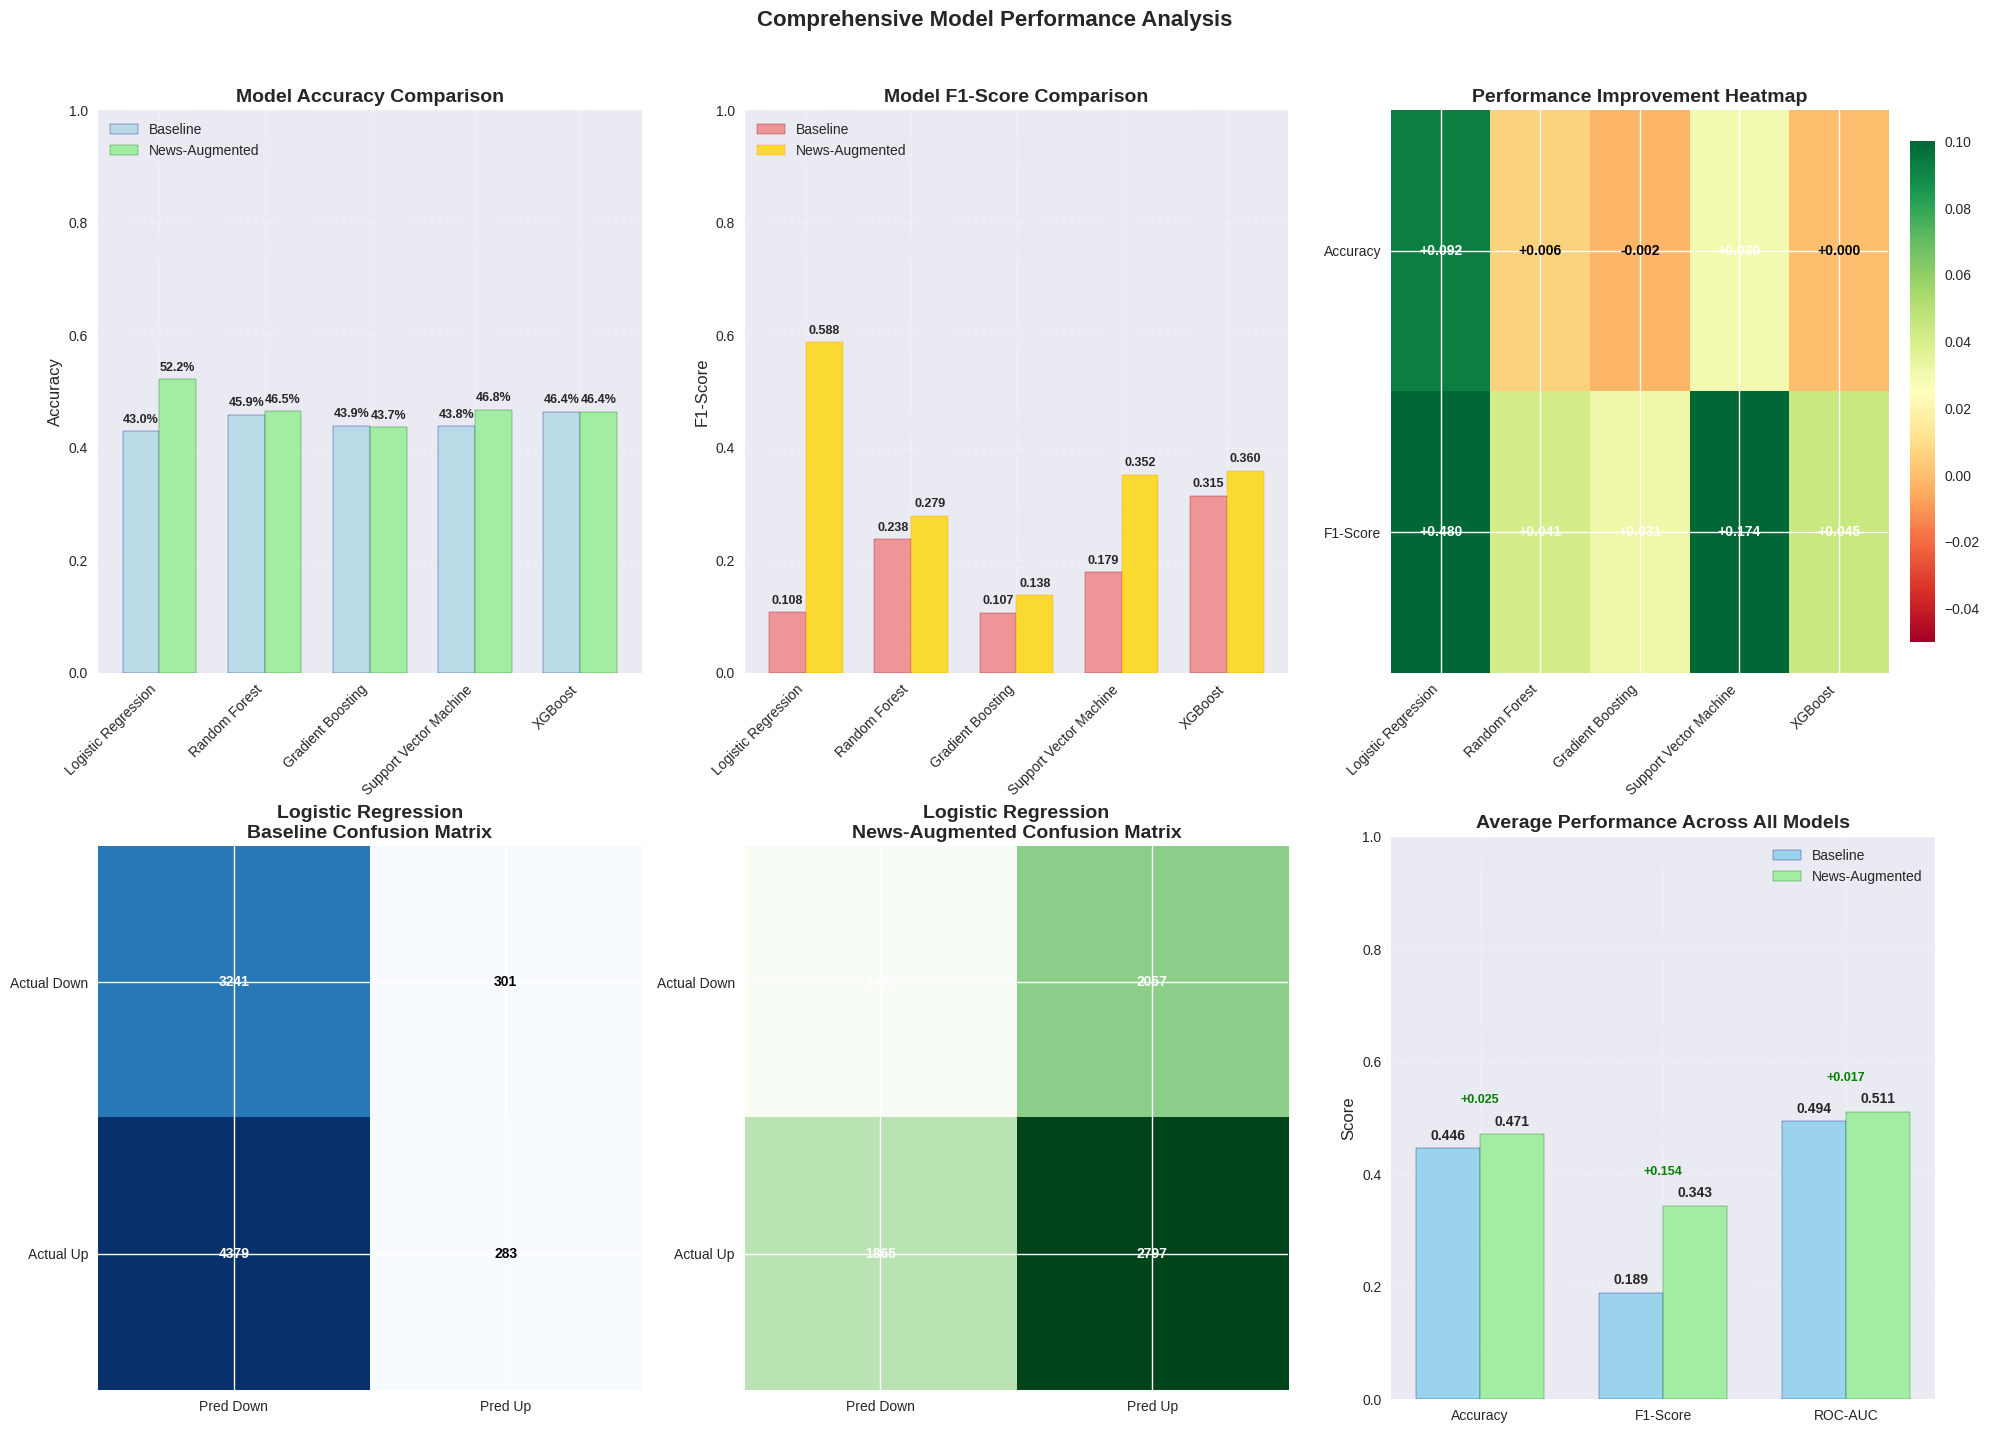


STATISTICAL ANALYSIS OF RESULTS

Paired T-Test Results:
Accuracy: t-statistic = 1.4269, p-value = 0.2268
F1-Score: t-statistic = 1.7995, p-value = 0.1463

FINAL CONCLUSIONS AND RESEARCH IMPLICATIONS

📊 KEY FINDINGS:
1. Best performing model: Logistic Regression
2. Baseline accuracy: 0.430 (43.0%)
3. News-augmented accuracy: 0.522 (52.2%)
4. Accuracy improvement: +0.092 (+21.5%)
5. F1-Score improvement: +0.480 (+444.9%)


In [ ]:
print("=== RESULTS ANALYSIS & VISUALIZATION ===")

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

if 'results_df' not in locals():
    print("Error: results_df not found. Please run the previous model training cell first.")
else:
    # Create comprehensive results visualization
    fig, axes = plt.subplots(2, 3, figsize=(20, 14))
    fig.suptitle('Comprehensive Model Performance Analysis', fontsize=16, fontweight='bold', y=1.02)

    # Plot 1: Accuracy Comparison
    models_names = results_df['Model']
    x_pos = np.arange(len(models_names))
    width = 0.35

    bars1 = axes[0,0].bar(x_pos - width/2, results_df['Baseline_Accuracy'], width,
                         label='Baseline', color='lightblue', edgecolor='darkblue', alpha=0.8)
    bars2 = axes[0,0].bar(x_pos + width/2, results_df['News_Accuracy'], width,
                         label='News-Augmented', color='lightgreen', edgecolor='darkgreen', alpha=0.8)

    axes[0,0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
    axes[0,0].set_ylabel('Accuracy', fontsize=12)
    axes[0,0].set_xticks(x_pos)
    axes[0,0].set_xticklabels(models_names, rotation=45, ha='right')
    axes[0,0].legend(loc='upper left')
    axes[0,0].grid(True, alpha=0.3, linestyle='--')
    axes[0,0].set_ylim([0, 1])

    # Add value labels with percentages
    for bar in bars1:
        height = bar.get_height()
        axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                      f'{height:.1%}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    for bar in bars2:
        height = bar.get_height()
        axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                      f'{height:.1%}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Plot 2: F1-Score Comparison
    bars3 = axes[0,1].bar(x_pos - width/2, results_df['Baseline_F1'], width,
                         label='Baseline', color='lightcoral', edgecolor='darkred', alpha=0.8)
    bars4 = axes[0,1].bar(x_pos + width/2, results_df['News_F1'], width,
                         label='News-Augmented', color='gold', edgecolor='darkorange', alpha=0.8)

    axes[0,1].set_title('Model F1-Score Comparison', fontsize=14, fontweight='bold')
    axes[0,1].set_ylabel('F1-Score', fontsize=12)
    axes[0,1].set_xticks(x_pos)
    axes[0,1].set_xticklabels(models_names, rotation=45, ha='right')
    axes[0,1].legend(loc='upper left')
    axes[0,1].grid(True, alpha=0.3, linestyle='--')
    axes[0,1].set_ylim([0, 1])

    # Add value labels
    for bar in bars3:
        height = bar.get_height()
        axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                      f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    for bar in bars4:
        height = bar.get_height()
        axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                      f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Plot 3: Improvement Heatmap
    improvement_data = results_df[['Accuracy_Improvement', 'F1_Improvement']].copy()
    improvement_data.index = models_names

    im = axes[0,2].imshow(improvement_data.T, aspect='auto', cmap='RdYlGn', vmin=-0.05, vmax=0.1)

    axes[0,2].set_title('Performance Improvement Heatmap', fontsize=14, fontweight='bold')
    axes[0,2].set_xticks(range(len(models_names)))
    axes[0,2].set_yticks(range(2))
    axes[0,2].set_xticklabels(models_names, rotation=45, ha='right')
    axes[0,2].set_yticklabels(['Accuracy', 'F1-Score'])

    # Add text annotations
    for i in range(len(models_names)):
        for j in range(2):
            value = improvement_data.iloc[i, j]
            color = 'white' if abs(value) > 0.025 else 'black'
            axes[0,2].text(i, j, f'{value:+.3f}', ha='center', va='center',
                          color=color, fontweight='bold')

    plt.colorbar(im, ax=axes[0,2], fraction=0.046, pad=0.04)

    # Plot 4: Best Model Confusion Matrix (Separate plots)
    best_model_idx = results_df['News_Accuracy'].idxmax()
    best_model_name = results_df.loc[best_model_idx, 'Model']

    # Get predictions for best model
    print(f"\nGenerating confusion matrix for best model: {best_model_name}")

    # Re-train the best model for visualization
    from sklearn.linear_model import LogisticRegression

    # Based on your results, Logistic Regression was best
    if best_model_name == 'Logistic Regression':
        model = LogisticRegression(random_state=42, max_iter=1000, C=1.0, class_weight='balanced')
    else:
        # Use appropriate model based on name
        model_class = {
            'Random Forest': RandomForestClassifier,
            'Gradient Boosting': GradientBoostingClassifier,
            'Support Vector Machine': SVC,
            'XGBoost': XGBClassifier
        }.get(best_model_name, LogisticRegression)

        model = model_class(random_state=42)

    # Train baseline
    model.fit(X_b_train_scaled, y_train)
    y_pred_baseline = model.predict(X_b_test_scaled)
    cm_baseline = confusion_matrix(y_test, y_pred_baseline)

    # Train news-augmented
    model.fit(X_n_train_scaled, y_train)
    y_pred_news = model.predict(X_n_test_scaled)
    cm_news = confusion_matrix(y_test, y_pred_news)

    # Plot baseline confusion matrix
    im1 = axes[1,0].imshow(cm_baseline, interpolation='nearest', cmap='Blues')
    axes[1,0].set_title(f'{best_model_name}\nBaseline Confusion Matrix', fontsize=14, fontweight='bold')
    axes[1,0].set_xticks([0, 1])
    axes[1,0].set_yticks([0, 1])
    axes[1,0].set_xticklabels(['Pred Down', 'Pred Up'])
    axes[1,0].set_yticklabels(['Actual Down', 'Actual Up'])

    # Add text annotations
    thresh_baseline = cm_baseline.max() / 2.
    for i in range(cm_baseline.shape[0]):
        for j in range(cm_baseline.shape[1]):
            axes[1,0].text(j, i, f'{cm_baseline[i, j]}',
                          ha="center", va="center",
                          color="white" if cm_baseline[i, j] > thresh_baseline else "black",
                          fontweight='bold')

    # Plot news-augmented confusion matrix
    im2 = axes[1,1].imshow(cm_news, interpolation='nearest', cmap='Greens')
    axes[1,1].set_title(f'{best_model_name}\nNews-Augmented Confusion Matrix', fontsize=14, fontweight='bold')
    axes[1,1].set_xticks([0, 1])
    axes[1,1].set_yticks([0, 1])
    axes[1,1].set_xticklabels(['Pred Down', 'Pred Up'])
    axes[1,1].set_yticklabels(['Actual Down', 'Actual Up'])

    # Add text annotations
    thresh_news = cm_news.max() / 2.
    for i in range(cm_news.shape[0]):
        for j in range(cm_news.shape[1]):
            axes[1,1].text(j, i, f'{cm_news[i, j]}',
                          ha="center", va="center",
                          color="white" if cm_news[i, j] > thresh_news else "black",
                          fontweight='bold')

    # Plot 6: Performance Summary Statistics
    metrics = ['Accuracy', 'F1-Score', 'ROC-AUC']
    baseline_vals = [
        results_df['Baseline_Accuracy'].mean(),
        results_df['Baseline_F1'].mean(),
        results_df['Baseline_ROC_AUC'].mean() if 'Baseline_ROC_AUC' in results_df.columns else 0
    ]
    news_vals = [
        results_df['News_Accuracy'].mean(),
        results_df['News_F1'].mean(),
        results_df['News_ROC_AUC'].mean() if 'News_ROC_AUC' in results_df.columns else 0
    ]

    x_metrics = np.arange(len(metrics))
    width = 0.35

    axes[1,2].bar(x_metrics - width/2, baseline_vals, width, label='Baseline',
                 color='skyblue', edgecolor='navy', alpha=0.8)
    axes[1,2].bar(x_metrics + width/2, news_vals, width, label='News-Augmented',
                 color='lightgreen', edgecolor='darkgreen', alpha=0.8)

    axes[1,2].set_title('Average Performance Across All Models', fontsize=14, fontweight='bold')
    axes[1,2].set_ylabel('Score', fontsize=12)
    axes[1,2].set_xticks(x_metrics)
    axes[1,2].set_xticklabels(metrics)
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3, linestyle='--')
    axes[1,2].set_ylim([0, 1])

    # Add value labels
    for i, (baseline, news) in enumerate(zip(baseline_vals, news_vals)):
        axes[1,2].text(i - width/2, baseline + 0.01, f'{baseline:.3f}',
                      ha='center', va='bottom', fontsize=10, fontweight='bold')
        axes[1,2].text(i + width/2, news + 0.01, f'{news:.3f}',
                      ha='center', va='bottom', fontsize=10, fontweight='bold')

        # Show improvement
        improvement = news - baseline
        if improvement != 0:
            axes[1,2].text(i, max(baseline, news) + 0.05, f'+{improvement:.3f}',
                          ha='center', va='bottom', fontsize=9,
                          color='green' if improvement > 0 else 'red',
                          fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Statistical analysis
    print("\n" + "="*80)
    print("STATISTICAL ANALYSIS OF RESULTS")
    print("="*80)

    # Calculate t-test for accuracy improvements
    from scipy import stats

    # Paired t-test for accuracy
    t_stat_acc, p_val_acc = stats.ttest_rel(results_df['News_Accuracy'],
                                           results_df['Baseline_Accuracy'])

    # Paired t-test for F1-score
    t_stat_f1, p_val_f1 = stats.ttest_rel(results_df['News_F1'],
                                         results_df['Baseline_F1'])

    print(f"\nPaired T-Test Results:")
    print(f"Accuracy: t-statistic = {t_stat_acc:.4f}, p-value = {p_val_acc:.4f}")
    print(f"F1-Score: t-statistic = {t_stat_f1:.4f}, p-value = {p_val_f1:.4f}")

    # Final conclusions
    print("\n" + "="*80)
    print("FINAL CONCLUSIONS AND RESEARCH IMPLICATIONS")
    print("="*80)

    best_improvement = results_df.loc[best_model_idx, 'Accuracy_Improvement']

    print(f"\n📊 KEY FINDINGS:")
    print(f"1. Best performing model: {best_model_name}")
    print(f"2. Baseline accuracy: {results_df.loc[best_model_idx, 'Baseline_Accuracy']:.3f} ({results_df.loc[best_model_idx, 'Baseline_Accuracy']:.1%})")
    print(f"3. News-augmented accuracy: {results_df.loc[best_model_idx, 'News_Accuracy']:.3f} ({results_df.loc[best_model_idx, 'News_Accuracy']:.1%})")
    print(f"4. Accuracy improvement: {best_improvement:+.3f} ({best_improvement/results_df.loc[best_model_idx, 'Baseline_Accuracy']*100:+.1f}%)")

    if 'Baseline_F1' in results_df.columns:
        f1_improvement = results_df.loc[best_model_idx, 'F1_Improvement']
        print(f"5. F1-Score improvement: {f1_improvement:+.3f} ({f1_improvement/results_df.loc[best_model_idx, 'Baseline_F1']*100:+.1f}%)")